In [25]:
import yfinance as yf
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller, coint
import statsmodels.api as sm

In [26]:
# Set some global variable
COL = 'Close'
ETF1 = 'SPY'
ETF2 = 'QQQ'
CONF = 0.05
LAG = 50

## Section 1: Time Series

In [27]:
end_date = datetime(2024, 2, 1)
start_date = end_date - timedelta(days=450)

# end_date = datetime.now()
# start_date = "2023-01-01"
# end_date = "2023-12-31"

# Download data as dataframe
ETF1_data = yf.download(ETF1, start=start_date, end=end_date).tail(300)
ETF2_data = yf.download(ETF2, start=start_date, end=end_date).tail(300)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [28]:
ETF1_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-18,397.739990,397.809998,393.040009,396.029999,388.317841,92922500
2022-11-21,394.640015,395.820007,392.660004,394.589996,386.905884,51243200
2022-11-22,396.630005,400.070007,395.149994,399.899994,392.112457,60429000
2022-11-23,399.549988,402.929993,399.309998,402.420013,394.583435,68261600
2022-11-25,401.829987,402.910004,401.540009,402.329987,394.495148,30545400
...,...,...,...,...,...,...
2024-01-25,487.579987,488.309998,485.390015,488.029999,488.029999,72525000
2024-01-26,487.589996,489.119995,486.540009,487.410004,487.410004,76641600
2024-01-29,487.730011,491.420013,487.170013,491.269989,491.269989,61322800


In [29]:
def plot_candlestick_graph(df, ticker):
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                    open=df['Open'],
                    high=df['High'],
                    low=df['Low'],
                    close=df['Close'])])
    
    fig.update_layout(
        width=1000,
        height=400,
        margin=dict(
            l=80,
            r=80,
            b=50,
            t=50
            ),
        title=f'Price Timeseries {ticker}',
        yaxis_title='Price')

    fig.show()
    
def plot_timeseries(df, col, ticker):
    plt.figure(figsize=(8,4))
    plt.plot(df[col])
    plt.title(f'Price over Time: {ticker}', fontsize=12)
    plt.ylabel(f'Price', fontsize=12)

    
plot_candlestick_graph(ETF1_data, ETF1)
plot_candlestick_graph(ETF2_data, ETF2)

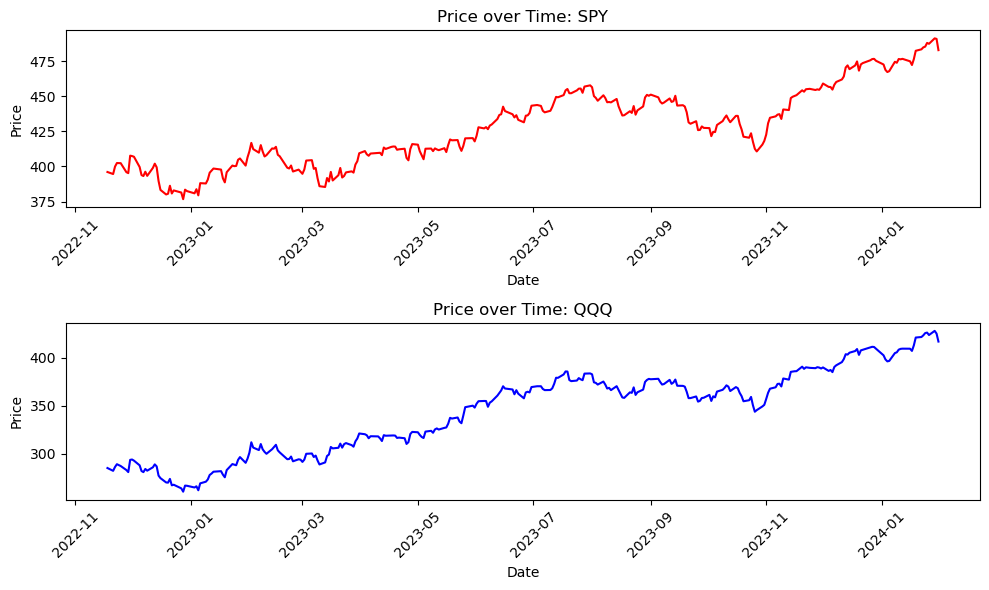

In [30]:

fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# First subplot
axs[0].plot(ETF1_data.index, ETF1_data[COL], 'r')  # 'r' is the color red
axs[0].set_title(f'Price over Time: {ETF1}')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')
axs[0].tick_params(axis='x', rotation=45)

# Second subplot
axs[1].plot(ETF2_data.index, ETF2_data[COL], 'b')  # 'b' is the color blue
axs[1].set_title(f'Price over Time: {ETF2}')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price')
axs[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

## Section 2: Moving Averages

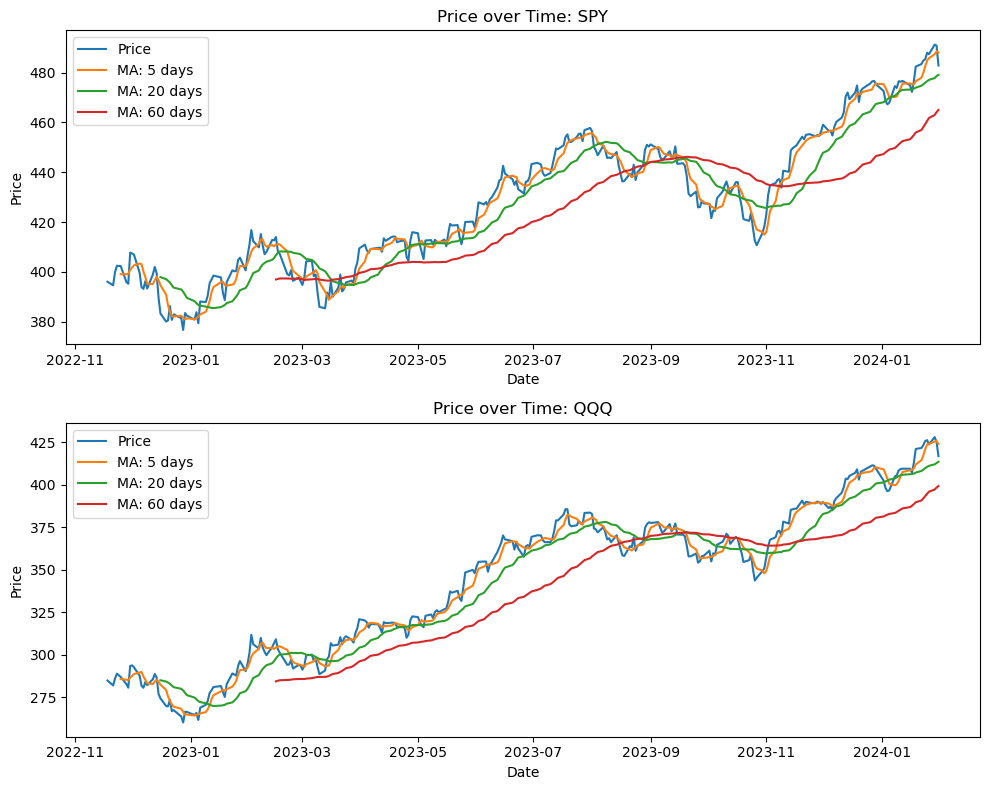

In [31]:
def get_moving_avg(df, col, lag):
    return df[col].rolling(window=lag).mean()

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].plot(ETF1_data.index, ETF1_data[COL], label = 'Price')
axs[0].plot(get_moving_avg(ETF1_data, COL, 5), label = 'MA: 5 days')
axs[0].plot(get_moving_avg(ETF1_data, COL, 20), label = 'MA: 20 days')
axs[0].plot(get_moving_avg(ETF1_data, COL, 60), label = 'MA: 60 days')
axs[0].set_title(f'Price over Time: {ETF1}')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')
axs[0].legend()

axs[1].plot(ETF2_data.index, ETF2_data[COL], label = 'Price')
axs[1].plot(get_moving_avg(ETF2_data, COL, 5), label = 'MA: 5 days')
axs[1].plot(get_moving_avg(ETF2_data, COL, 20), label = 'MA: 20 days')
axs[1].plot(get_moving_avg(ETF2_data, COL, 60), label = 'MA: 60 days')
axs[1].set_title(f'Price over Time: {ETF2}')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price')
axs[1].legend()

plt.tight_layout()

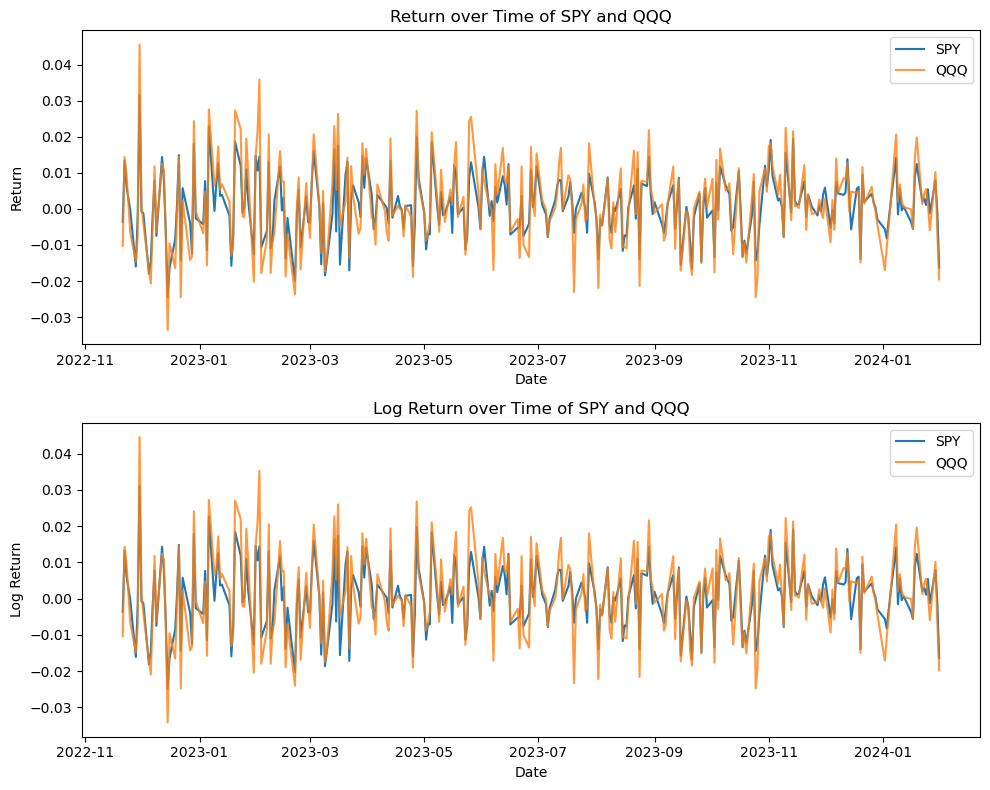

In [32]:
def get_return(data, col, log=False):
    
    if log:
        return np.log(np.array(data[col][1:]) / np.array(data[col][:-1]))
    else:
        # return (np.array(data[col][1:]) - np.array(data[col][:-1]))/np.array(data[col][1:])
        return data[col].pct_change().dropna()
    
fig, axs = plt.subplots(2, 1, figsize = (10, 8))

axs[0].plot(ETF1_data.index[1:], get_return(ETF1_data, COL), label=f'{ETF1}', alpha=1)
axs[0].plot(ETF2_data.index[1:],get_return(ETF2_data, COL), label=f'{ETF2}', alpha=0.8)

axs[0].set_title(f'Return over Time of {ETF1} and {ETF2}')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Return')
axs[0].legend()

axs[1].plot(ETF1_data.index[1:],get_return(ETF1_data, COL, log = True), label=f'{ETF1}', alpha=1)
axs[1].plot(ETF2_data.index[1:],get_return(ETF2_data, COL, log = True), label=f'{ETF2}', alpha=0.8)
axs[1].set_title(f'Log Return over Time of {ETF1} and {ETF2}')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Log Return')
axs[1].legend()

plt.tight_layout()

In [33]:
from statsmodels.tsa.arima.model import ARIMA

def arima_model(df, col, order, show_summary = False):
    # endog: "endogenous variable," which refers to the main variable of interest in your time series analysis. 
    ARIMA_model = ARIMA(endog=df[col], order=order)
    results = ARIMA_model.fit()
    if show_summary:
        print(results.summary())
    return results


# ma_5 = arima_model(df=ETF1_data, col=COL, order=(0, 0, 5), show_summary=True)


## Section 3: Correlation Functions

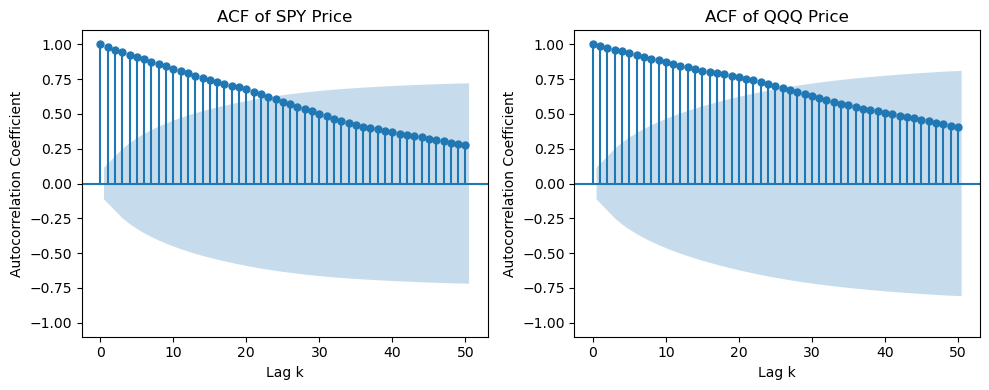

/Users/chenkangan/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



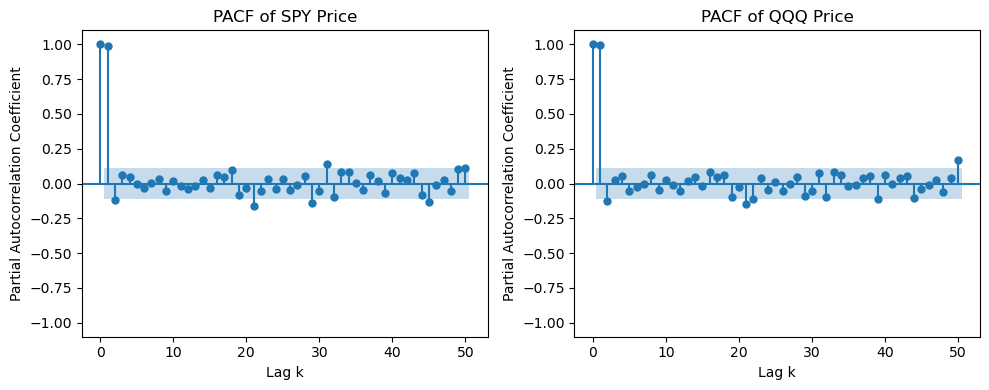

In [34]:
# Plot the ACF
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_acf(ETF1_data[COL], lags=LAG, ax=axs[0])  # You can adjust the number of lags as needed
axs[0].set_title(f'ACF of {ETF1} Price')
axs[0].set_xlabel('Lag k')
axs[0].set_ylabel('Autocorrelation Coefficient')
axs[0].set_ylim(-1.1, 1.1)

plot_acf(ETF2_data[COL], lags=LAG, ax=axs[1])  # You can adjust the number of lags as needed
axs[1].set_title(f'ACF of {ETF2} Price')
axs[1].set_xlabel('Lag k')
axs[1].set_ylabel('Autocorrelation Coefficient')
axs[1].set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.show()

# Plot the PACF
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_pacf(ETF1_data[COL], lags=LAG, ax=axs[0])  # You can adjust the number of lags as needed
axs[0].set_title(f'PACF of {ETF1} Price')
axs[0].set_xlabel('Lag k')
axs[0].set_ylabel('Partial Autocorrelation Coefficient')
axs[0].set_ylim(-1.1, 1.1)

plot_pacf(ETF2_data[COL], lags=LAG, ax=axs[1])  # You can adjust the number of lags as needed
axs[1].set_title(f'PACF of {ETF2} Price')
axs[1].set_xlabel('Lag k')
axs[1].set_ylabel('Partial Autocorrelation Coefficient')
axs[1].set_ylim(-1.1, 1.1)
plt.tight_layout()
plt.show()


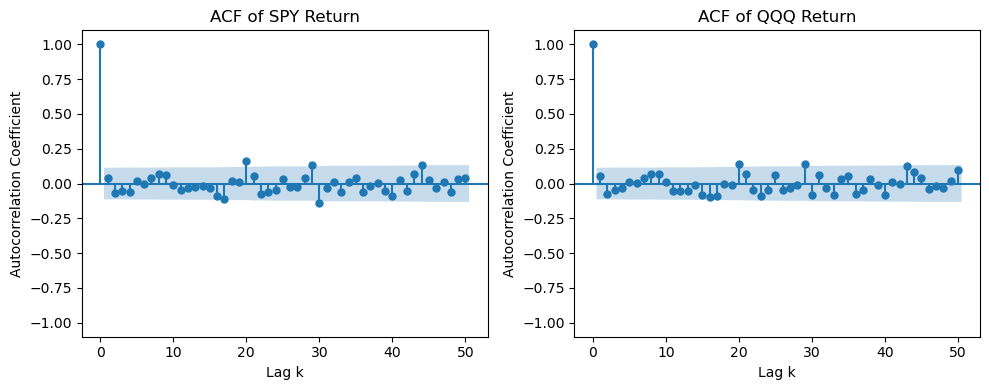

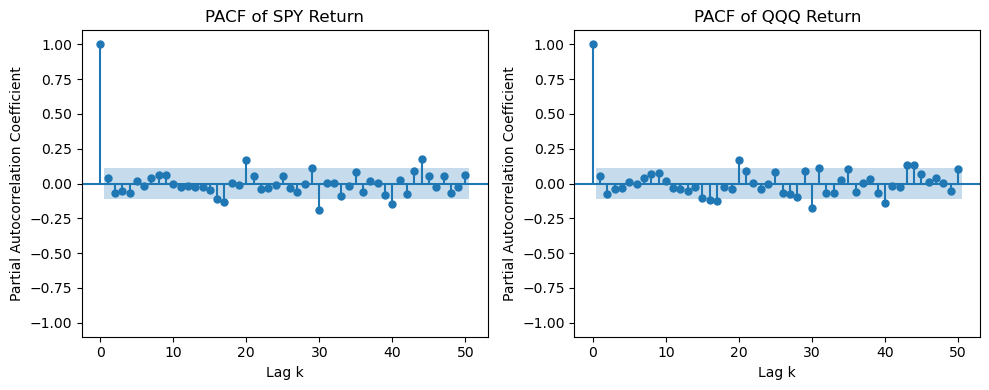

In [35]:


# Plot the ACF
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_acf(get_return(ETF1_data, COL), lags=LAG, ax=axs[0])  # You can adjust the number of lags as needed
axs[0].set_title(f'ACF of {ETF1} Return')
axs[0].set_xlabel('Lag k')
axs[0].set_ylabel('Autocorrelation Coefficient')
axs[0].set_ylim(-1.1, 1.1)

plot_acf(get_return(ETF2_data, COL), lags=LAG, ax=axs[1])  # You can adjust the number of lags as needed
axs[1].set_title(f'ACF of {ETF2} Return')
axs[1].set_xlabel('Lag k')
axs[1].set_ylabel('Autocorrelation Coefficient')
axs[1].set_ylim(-1.1, 1.1)
plt.tight_layout()
plt.show()
    
# Plot the PACF
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_pacf(get_return(ETF1_data, COL), lags=LAG, ax=axs[0])  # You can adjust the number of lags as needed
axs[0].set_title(f'PACF of {ETF1} Return')
axs[0].set_xlabel('Lag k')
axs[0].set_ylabel('Partial Autocorrelation Coefficient')
axs[0].set_ylim(-1.1, 1.1)

plot_pacf(get_return(ETF2_data, COL), lags=LAG, ax=axs[1])  # You can adjust the number of lags as needed
axs[1].set_title(f'PACF of {ETF2} Return')
axs[1].set_xlabel('Lag k')
axs[1].set_ylabel('Partial Autocorrelation Coefficient')
axs[1].set_ylim(-1.1, 1.1)
plt.tight_layout()
plt.show()

## Session 4: Gaussianity and Stationarity Test



In [36]:
# Test for Gaussianity using K-S test
ETF1_return = get_return(ETF1_data, COL)

# Perform the K-S test for normality
# Test assumes nomality H0
# If the pvalue is lower than some threshold, e.g. 0.05, then we can reject the Null hypothesis that the sample comes from a normal distribution.
ks_statistic, p_value = stats.kstest(ETF1_return, 'norm', args=(np.mean(ETF1_return), np.std(ETF1_return)))

print(f'Null hypothesis: {ETF1} return follows normal distribution.')
print(f"{ETF1} K-S statistic: {ks_statistic:4f}, p-value: {p_value:6f}")

if p_value < CONF:
      print(f'P value less than {CONF}, thus reject the null hypothesis.')
else:
      print(f'P value greater than {CONF}, thus fail to reject the null hypothesis.')

print('')
# Test for Gaussianity using K-S test
ETF2_return = get_return(ETF2_data, COL)

# Perform the K-S test for normality
ks_statistic, p_value = stats.kstest(ETF2_return, 'norm', args=(np.mean(ETF2_return), np.std(ETF2_return)))

print(f'Null hypothesis: {ETF2} return follows normal distribution.')
print(f"{ETF2} K-S statistic: {ks_statistic:4f}, p-value: {p_value:6f}")

if p_value < CONF:
      print(f'P value less than {CONF}, thus reject the null hypothesis.')
else:
      print(f'P value greater than {CONF}, thus fail to reject the null hypothesis.')


Null hypothesis: SPY return follows normal distribution.
SPY K-S statistic: 0.038539, p-value: 0.751145
P value greater than 0.05, thus fail to reject the null hypothesis.

Null hypothesis: QQQ return follows normal distribution.
QQQ K-S statistic: 0.032622, p-value: 0.897485
P value greater than 0.05, thus fail to reject the null hypothesis.


In [37]:

# The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.
w_statistic, p_value = stats.shapiro(ETF1_return)

print(f'Null hypothesis: {ETF1} return follows normal distribution.')
print(f"{ETF1} Shapiro-Wilk statistic: {w_statistic:4f}, p-value: {p_value:6f}")

if p_value < CONF:
      print(f'P value less than {CONF}, thus reject the null hypothesis.')
else:
      print(f'P value greater than {CONF}, thus fail to reject the null hypothesis.')

print('')
w_statistic, p_value = stats.shapiro(ETF2_return)

print(f'Null hypothesis: {ETF2} return follows normal distribution.')
print(f"{ETF2} Shapiro-Wilk statistic: {w_statistic:4f}, p-value: {p_value:6f}")

if p_value < CONF:
      print(f'P value less than {CONF}, thus reject the null hypothesis.')
else:
      print(f'P value greater than {CONF}, thus fail to reject the null hypothesis.')

Null hypothesis: SPY return follows normal distribution.
SPY Shapiro-Wilk statistic: 0.993895, p-value: 0.270907
P value greater than 0.05, thus fail to reject the null hypothesis.

Null hypothesis: QQQ return follows normal distribution.
QQQ Shapiro-Wilk statistic: 0.995057, p-value: 0.454456
P value greater than 0.05, thus fail to reject the null hypothesis.


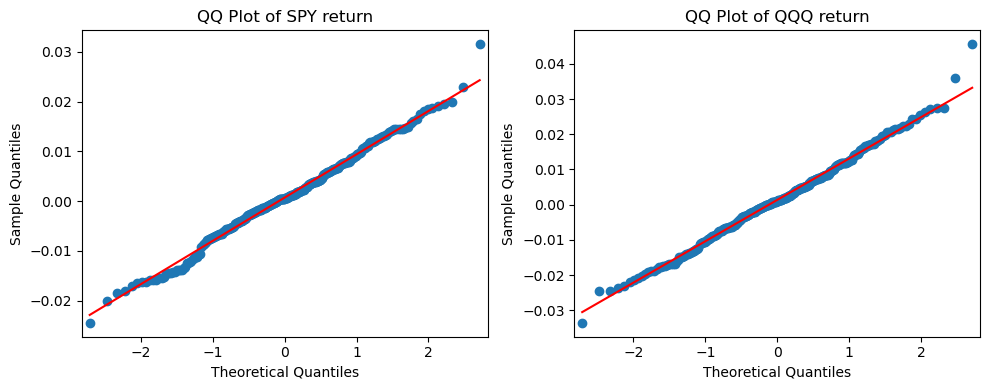

In [38]:
import statsmodels.api as sm
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
 # The 'line' parameter adds a reference line at 45 degrees which represents the theoretical normal distribution 
sm.qqplot(ETF1_return, ax = axs[0], line='s') 
sm.qqplot(ETF2_return, ax = axs[1], line='s') 
axs[0].set_title(f'QQ Plot of {ETF1} return')
axs[1].set_title(f'QQ Plot of {ETF2} return')
plt.tight_layout()
plt.show()  # Display the plot

In [39]:
# Stationarity test

ETF1_result = adfuller(ETF1_return)

print(f'Null hypothesis: {ETF1} return is not stationary.')
print(f"{ETF1} Augmented Dickey-Fuller test statistic: {ETF1_result[0]: 4f}, p-value: {ETF1_result[1]: 4f}")

if ETF1_result[1] < CONF:
      print(f'P value less than {CONF}, thus reject the null hypothesis.')
else:
      print(f'P value greater than {CONF}, thus fail to reject the null hypothesis.')

print('')

ETF2_result = adfuller(ETF2_return)

print(f'Null hypothesis: {ETF2} return is not stationary.')
print(f"{ETF2} Augmented Dickey-Fuller test statistic: {ETF2_result[0]: 4f}, p-value: {ETF2_result[1]: 4f}")


if ETF1_result[2] < CONF:
      print(f'P value less than {CONF}, thus reject the null hypothesis.')
else:
      print(f'P value greater than {CONF}, thus fail to reject the null hypothesis.')


Null hypothesis: SPY return is not stationary.
SPY Augmented Dickey-Fuller test statistic: -16.382702, p-value:  0.000000
P value less than 0.05, thus reject the null hypothesis.

Null hypothesis: QQQ return is not stationary.
QQQ Augmented Dickey-Fuller test statistic: -16.210782, p-value:  0.000000
P value less than 0.05, thus reject the null hypothesis.


## Session 5: Cointegration Test

In [40]:
# Perform the Engle-Granger cointegration test
coint_t, p_value, crit_value = coint(ETF1_data[COL], ETF2_data[COL])

print('Cointegration test statistic:', round(coint_t, 4))
print('P-value:', round(p_value, 4))
print('Critical Values:', crit_value)

# Interpret the results
if p_value < CONF:
    print("The series are cointegrated.")
else:
    print("The series are not cointegrated.")

Cointegration test statistic: -2.0866
P-value: 0.4834
Critical Values: [-3.93344345 -3.35664144 -3.05866504]
The series are not cointegrated.


In [41]:
# Perform the Engle-Granger cointegration test
coint_t, p_value, crit_value = coint(ETF1_return, ETF2_return)

print('Cointegration test statistic:', round(coint_t, 4))
print('P-value:', round(p_value, 4))
print('Critical Values:', crit_value)

# Interpret the results
if p_value < CONF:
    print("The series are cointegrated.")
else:
    print("The series are not cointegrated.")

Cointegration test statistic: -17.3126
P-value: 0.0
Critical Values: [-3.93356888 -3.35671052 -3.05871284]
The series are cointegrated.


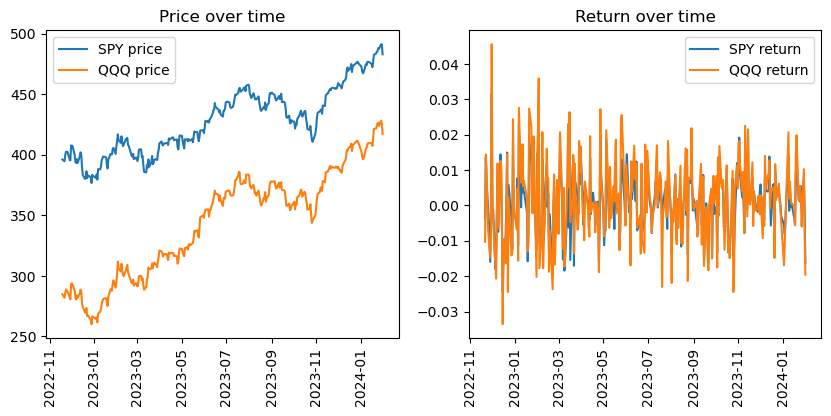

In [42]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))

axs[0].plot(ETF1_data[COL], label = f'{ETF1} price')
axs[0].plot(ETF2_data[COL], label = f'{ETF2} price')
axs[0].tick_params(axis='x', rotation=90)
axs[0].set_title('Price over time')
axs[0].legend()

axs[1].plot(ETF1_data[COL].index[1:], ETF1_return, label = f'{ETF1} return')
axs[1].plot(ETF1_data[COL].index[1:], ETF2_return, label = f'{ETF2} return')
axs[1].tick_params(axis='x', rotation=90)
axs[1].set_title('Return over time')
axs[1].legend()